In [5]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
proj_dir = os.path.abspath('../..')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy import stats
from scipy.spatial import distance
from scipy import ndimage
from scipy.stats import entropy
from random import random
from sklearn.cluster import SpectralBiclustering
import sklearn.metrics as metrics
import itertools

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import colors

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.orca.config.use_xvfb = False
plotly.io.orca.config.save()

import importlib
import trajectory as g

import nltk
nltk.download('punkt')

from collections import Counter

[nltk_data] Downloading package punkt to /Users/will/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(analysis_dir,'results')
stim_dir = os.path.join(proj_dir,'stimuli')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

# Human Data

### load in data

In [7]:
iteration_name = 'Exp2Pilot3_all'
num_trials = 24 #for sanity checks

In [8]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}_good.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}_good.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}_good.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

105 participants total


### apply preprocessing

In [77]:
targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
reps = np.sort(df['repetition'].unique())

dfi['usableDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
dfi['flatDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: (1+(-1)*np.array(ast.literal_eval(a))).flatten())

dfic = dfi.copy()
#dfic = dfi[dfi.condition=='repeated']
dfic = dfic[['trialNum','targetName','gameID','blockNum','repetition','phase_extended','flatDiscreteWorld','usableDiscreteWorld','rawF1DiscreteScore']]
dfic['discreteWorld'] = dfic['usableDiscreteWorld']
dfic['flatDiscreteWorldStr'] = dfic['flatDiscreteWorld'].apply(g.convert_to_str)

#add perfectScore column
dfic = dfic.merge(df[['trialNum','gameID','perfectScore']], how='left', on=['trialNum','gameID'])

max_actions = dfic['blockNum'].max()

In [11]:
def add_ngrams_to_dict(world_states, n, counts):
    n_grams = nltk.ngrams(world_states, n)
    for grams in n_grams:
        counts[' '.join(grams)] = counts.get(' '.join(grams), 0) + 1

def gini_coefficient(visits):
    visits = np.array(visits)[:,None]
    numerator = np.sum(metrics.pairwise_distances(visits))
    denomenator = 2 * (len(visits)**2) * np.mean(visits)
    if denomenator == 0:
        g = 0
    else:
        g = numerator/denomenator
    return g

In [8]:
results_h = pd.DataFrame(columns=['targetName','phase','gini'])

G = {}
for target in targets:
    G[target] = {}
    for phase in ['pre','post']:
        G[target][phase] = {}
        df_phase = dfic[(dfic.targetName==target) & (dfic.phase_extended==phase)]
        for n in range(1,11):
            counts = {}
            df_phase.groupby(['gameID'])['flatDiscreteWorldStr']\
                        .agg(lambda ws: add_ngrams_to_dict(list(ws),n,counts))
            visits = list(counts.values())
            G[target][phase][n] = gini_coefficient(visits)

#     target_df = pd.DataFrame.from_dict(G[target])
#     target_df['n'] = target_df.index
#     target_df = target_df.melt()\
#                         .rename(columns={'variable':'iter','value':'gini'})
    
#     target_df['targetName'] = target
#     results = results.append(this,sort=False)
            
for target in targets:
    target_df = pd.DataFrame.from_dict(G[target],orient='index')
    target_df.columns = target_df.columns.map(lambda x: 'gini'+str(x))
    target_df['phase'] = target_df.index
    target_df = pd.wide_to_long(target_df, stubnames='gini', i=['phase'], j='nlevel')
    target_df['targetName'] = target
    target_df = target_df.reset_index()
    results_h = results_h.append(target_df,sort=False)

In [13]:
results_h = pd.DataFrame(columns=['targetName','phase','gini'])

G = {}

for target in targets:
    G[target] = {}
    for phase in ['pre','post']:
        G[target][phase] = {}
        df_phase = dfic[(dfic.targetName==target) & (dfic.phase_extended==phase)]
        for n in range(1,11):
            counts = {}
            df_phase.groupby(['gameID'])['flatDiscreteWorldStr']\
                        .agg(lambda ws: add_ngrams_to_dict(list(ws),n,counts))
            visits = list(counts.values())
            G[target][phase][n] = gini_coefficient(visits)
            
        

[28, 7, 5, 2, 29, 7, 4, 5, 55, 50, 4, 5, 1, 1, 1, 13, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 11, 5, 5, 1, 9, 4, 2, 2, 1, 1, 1, 1, 1, 6, 1, 3, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 6, 3, 5, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 1, 1, 11, 5, 1, 1, 5, 4, 4, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 6, 1, 3, 2, 1, 1, 4, 3, 2, 1, 1, 1, 1, 1, 1, 13, 1, 1, 1, 1, 1, 4, 2, 5, 3, 1, 1, 1, 6, 1, 5, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 6, 3, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1

[3, 4, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 6, 6, 1, 1, 1, 1, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1, 1, 2, 1, 2, 2, 1, 6, 2, 1, 1, 1, 1, 3, 10, 8, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 3, 3, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[48, 12, 5, 2, 1, 1, 20, 4, 1, 5, 1, 1, 1, 40, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 16, 23, 12, 4, 1, 1, 1, 1, 1, 2, 2, 1, 1, 34, 2, 10, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 20, 11, 5, 7, 3, 3, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 8, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 5, 1, 1, 1, 1, 1, 1, 2, 5, 5, 7, 8, 7, 7, 7, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 5, 5, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

[1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[30, 64, 21, 9, 28, 6, 1, 1, 1, 1, 3, 1, 2, 12, 7, 1, 1, 5, 9, 4, 1, 1, 1, 1, 2, 2, 5, 1, 1, 4, 3, 1, 1, 1, 1, 1, 1, 1, 9, 5, 3, 14, 35, 4, 1, 1, 1, 1, 14, 1, 3, 4,

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

[2, 2, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 3, 3, 1, 2, 1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3, 5, 5, 2, 3, 4, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 5, 4, 3, 3, 1, 2, 2, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 

In [14]:
def get_ngrams(world_states, n):
    return nltk.ngrams(world_states, n)

In [15]:
targetMaps = {}

with open(os.path.join(csv_dir,'targetMaps.txt')) as json_file:
    targetMaps = json.load(json_file)


def show_chunk(states, ax, target=None, vmax=None, cmap='Blues', **kwargs):
    start_state_int = np.reshape(list(states[0]),(18,13)).astype(np.int)
    end_state_int = np.reshape(list(states[-1]),(18,13)).astype(np.int)
    chunk = np.bitwise_xor(start_state_int, end_state_int).astype(np.int)
    chunk_plus = end_state_int + chunk
    
    if target:
        chunk_plus = chunk_plus + (1*np.logical_not(targetMaps[target]))*0.2
    
    av_map = np.rot90(chunk_plus)
    
    if ~(vmax==None):
        ax.imshow(av_map, 
                  vmax= vmax,
                  cmap=cmap,
                **kwargs)
    else:
        ax.imshow(av_map,
                  cmap=cmap,
                **kwargs)
        
        
def show_chunk_steps(states, ax, target=None, vmax=None, cmap='Blues', **kwargs):
    
    start_state = np.reshape(list(states[0]),(18,13)).astype(np.int)
    end_state = np.reshape(list(states[-1]),(18,13)).astype(np.int)
    chunk = np.bitwise_xor(start_state, end_state).astype(np.float)
    
    chunk_plus = end_state.astype(np.float) + chunk*0.5
    
#      if target:
#         chunk_plus = chunk_plus - (1*np.logical_not(targetMaps[target]))*0.4
    
    if target:
        world_map = (1*np.logical_not(targetMaps[target]))*0.2
        chunk_plus += world_map
    
    
    for s in states[:-1]:
        chunk_plus -= np.reshape(list(s),(18,13)).astype(np.float)*0.2
    
    av_map = np.rot90(chunk_plus)
    
    if ~(vmax==None):
        ax.imshow(av_map, 
                  vmax= vmax,
                  cmap=cmap,
                **kwargs)
    else:
        ax.imshow(av_map,
                  cmap=cmap,
                **kwargs)

In [17]:
## For one structure, for one length

# filter for one structure
target = targets[1]
df_target = dfic[(dfic.targetName==target)]

# make a dataframe grouped by each time it is built (gameID, phase)
df_target_grouped = df_target.groupby(['gameID','phase_extended'])['flatDiscreteWorldStr']

# Calculate the ngrams of a particular length for those groups
n = 5
ngram_series = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), n))).reset_index()['flatDiscreteWorldStr']

ngram_list = [ngram for row in ngram_series for ngram in row]

# print(ngram_series.apply(len).agg(sum)) sanity check
# print(len(ngram_list))

# Go through and count occurrences of each

ngram_counts = Counter(ngram_list)

# Return top k
k = 5
top_k = ngram_counts.most_common(k)

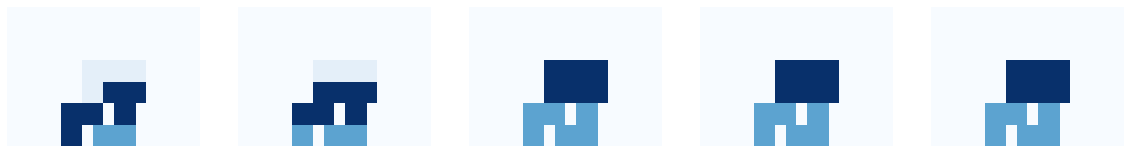

In [18]:
## for each ngram, draw the sequence of world states in one image (minus the rest of the image)

fig, axs = plt.subplots(1, k, figsize=(20,6))

for j in range(0,k):
    start_state = top_k[j][0][0]
    end_state = top_k[j][0][n-1]

    axs[j].axis('off')
    
    show_chunk(top_k[j][0], axs[j], target=target)
    

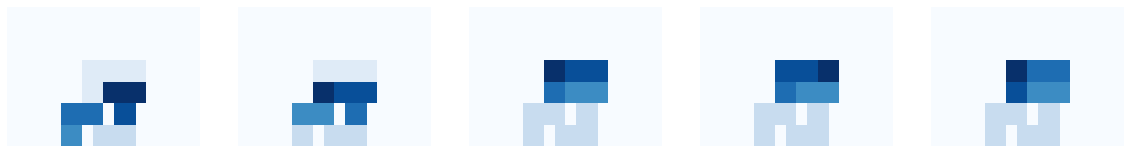

In [101]:
## for each ngram, draw the sequence of world states in one image (minus the rest of the image)

fig, axs = plt.subplots(1, k, figsize=(20,6))

for j in range(0,k):
    states = top_k[j][0]
    axs[j].axis('off')
    show_chunk_steps(states, axs[j], target=target)
    

### ngrams to identify chunks

In [19]:
# this method uses sequences of states to identify chunks. 
# therefore the first state displayed below isn't a block placement. 

chunk_size = 5 # number of blocks + 1 for initial state
k = 5 # take top k most frequent chunks

# make a dataframe with a group for each reconstruction
df_target_grouped = dfic.groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

# Calculate the ngrams of a particular length for each reconstruction
df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()

ngram_list = {}
ngram_counts = {}
top_k = {}

for t in targets:
    # for each target, put the ngrams from all reconstructions into list
    ngram_list[t] = [ngram for row in df_ngrams[df_ngrams.targetName==t]['flatDiscreteWorldStr'] for ngram in row]
    ngram_counts[t] = Counter(ngram_list[t]) # count occurrences of each ngram across ppts
    top_k[t] = ngram_counts[t].most_common(k)
    
# print(ngram_series.apply(len).agg(sum)) sanity check
# print(len(ngram_list))

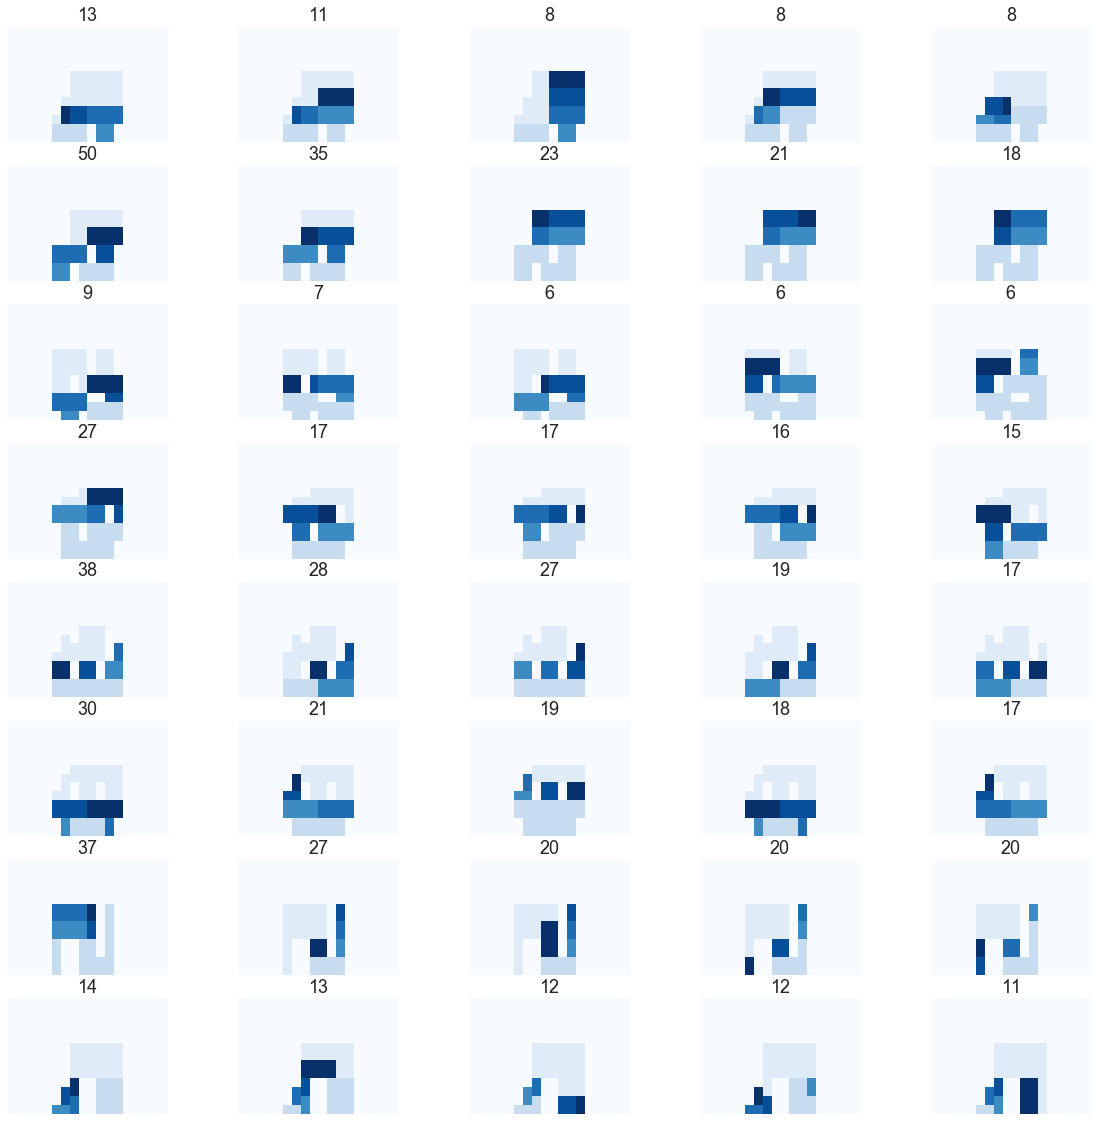

In [20]:
## for each ngram, draw the sequence of world states in one image (minus the rest of the image)

fig, axs = plt.subplots(len(targets), k, figsize=(20,20))

for i, t in enumerate(targets):
    for j in range(0,k):
        states = top_k[t][j][0]

        axs[i,j].axis('off')
        axs[i,j].set_title(str(top_k[t][j][1]))

        show_chunk_steps(states, axs[i,j], target = t)

## Next steps!

### definition of chunks
Currently this is only displaying n-1 blocks, because the first state of the ngram is just that- a state.

An easier next step is to group by start state and end state (so not ngrams.. call them ngaps?!), but this makes them dependent on the starting state. This might end up being useful, but I think it's more likely chunks are at least separable from their initial state- so multiple states could be in the 'input set'. 

So the next step would be to look at the *difference* ('∆world') in world state (i.e. independent of starting state). 
Although these could also have a variable numbers of blocks- we'd need a way of choosing start and end states.
We could compute them all? Presumably there would be a lots near the beginning, and lots that spanned the whole trial (i.e. building the whole structure). 
But we could find mid-sized areas somehow- what defines a mid-sized area? Not number of blocks (but I guess they would have to be more than one block, so maybe any ∆world that takes a minimum of two blocks, and isn't the whole or nearly the whole structure).
(would/could we make these translation-invariant?)


Both of these methods are unconstrained by spatial continuity, which maybe should be a factor.




### first and last states

In [21]:
# this method uses first and last state states of ngrams of a given length to identify chunks. 
# therefore the first state displayed below isn't a block placement. 

chunk_size = 5 # number of blocks + 1 for initial state
k = 5 # take top k most frequent chunks

# make a dataframe with a group for each reconstruction
df_target_grouped = dfic.groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

# Calculate the ngrams of a particular length for each reconstruction
df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()

ngram_list = {}
first_last = {}
first_last_counts = {}
top_k_first_last = {}

for t in targets:
    # for each target, put the ngrams from all reconstructions into list
    ngram_list[t] = [ngram for row in df_ngrams[df_ngrams.targetName==t]['flatDiscreteWorldStr'] for ngram in row]
    first_last[t] = [(ngram[0], ngram[-1]) for ngram in ngram_list[t]]
    first_last_counts[t] = Counter(first_last[t]) # count occurrences of each ngram across ppts
    top_k_first_last[t] = first_last_counts[t].most_common(k)
    
# print(ngram_series.apply(len).agg(sum)) sanity check
# print(len(ngram_list))

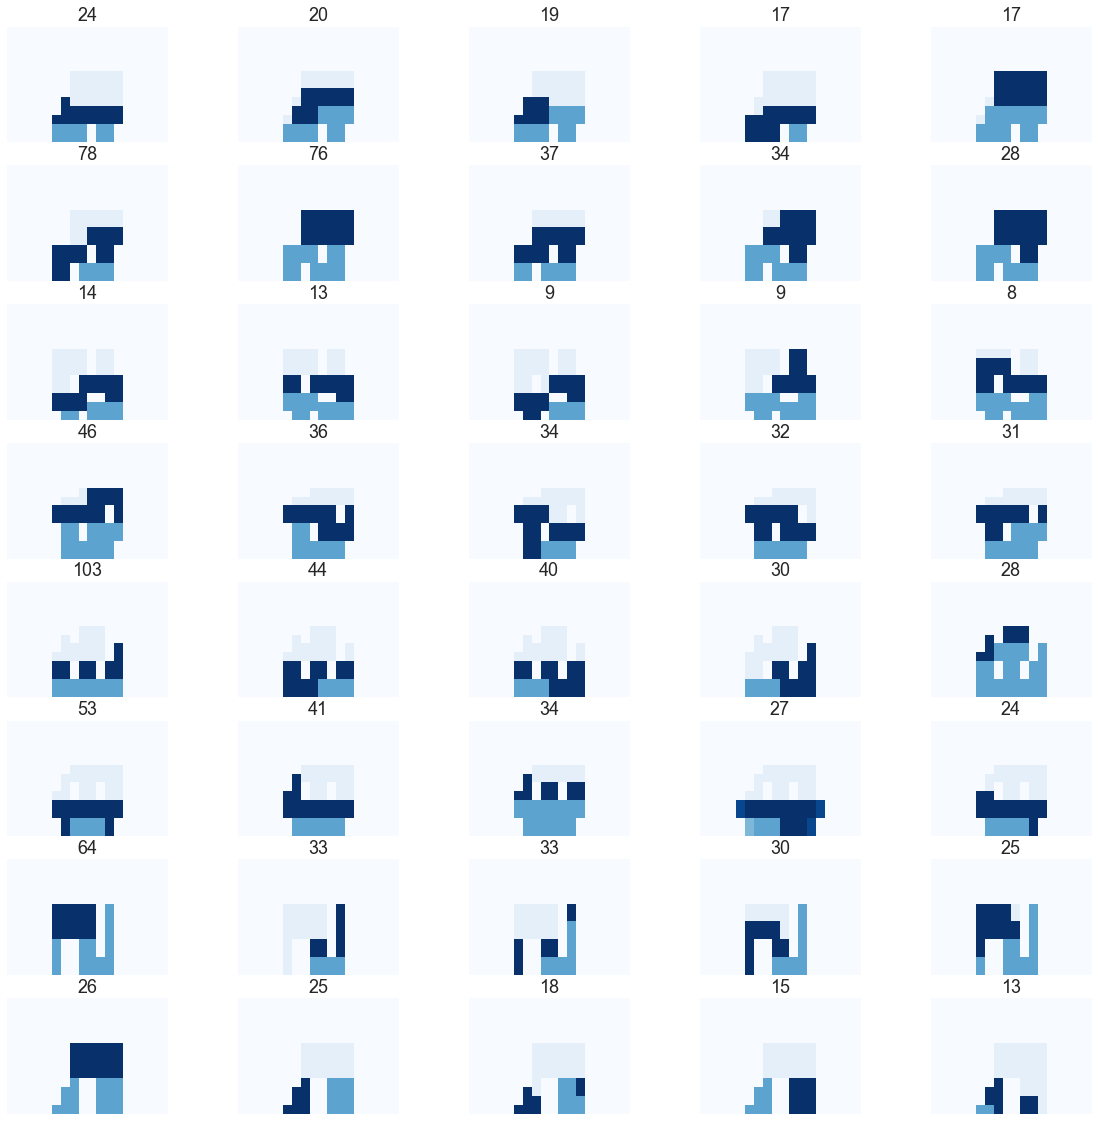

In [22]:
## for each ngram, draw the sequence of world states in one image (minus the rest of the image)

fig, axs = plt.subplots(len(targets), k, figsize=(20,20))

for i, t in enumerate(targets):
    for j in range(0,k):
        states = top_k_first_last[t][j][0]

        axs[i,j].axis('off')
        axs[i,j].set_title(str(top_k_first_last[t][j][1]))

        show_chunk(states, axs[i,j], target = t)


As before, this method relies on the same start state.

### Difference between first and last states (i.e. independent of starting state)

In [23]:
# this method uses first and last state states of ngrams of a given length to identify chunks. 
# therefore the first state displayed below isn't a block placement. 

chunk_size = 4 # number of blocks + 1 for initial state
k = 5 # take top k most frequent chunks

# make a dataframe with a group for each reconstruction
df_target_grouped = dfic.groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

# Calculate the ngrams of a particular length for each reconstruction
df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()

ngram_list = {}
diff = {}
diff_counts = {}
top_k_diff = {}

for t in targets:
    # for each target, put the ngrams from all reconstructions into list
    ngram_list[t] = [ngram for row in df_ngrams[df_ngrams.targetName==t]['flatDiscreteWorldStr'] for ngram in row]
    diff[t] = ["".join([str(a) for a in 
                  list((np.array(list(ngram[-1])).astype(np.int) - 
                     np.array(list(ngram[0])).astype(np.int)))]) for ngram in ngram_list[t]]
    diff_counts[t] = Counter(diff[t]) # count occurrences of each ngram across ppts
    top_k_diff[t] = diff_counts[t].most_common(k)

    
# print(ngram_series.apply(len).agg(sum)) sanity check
# print(len(ngram_list))

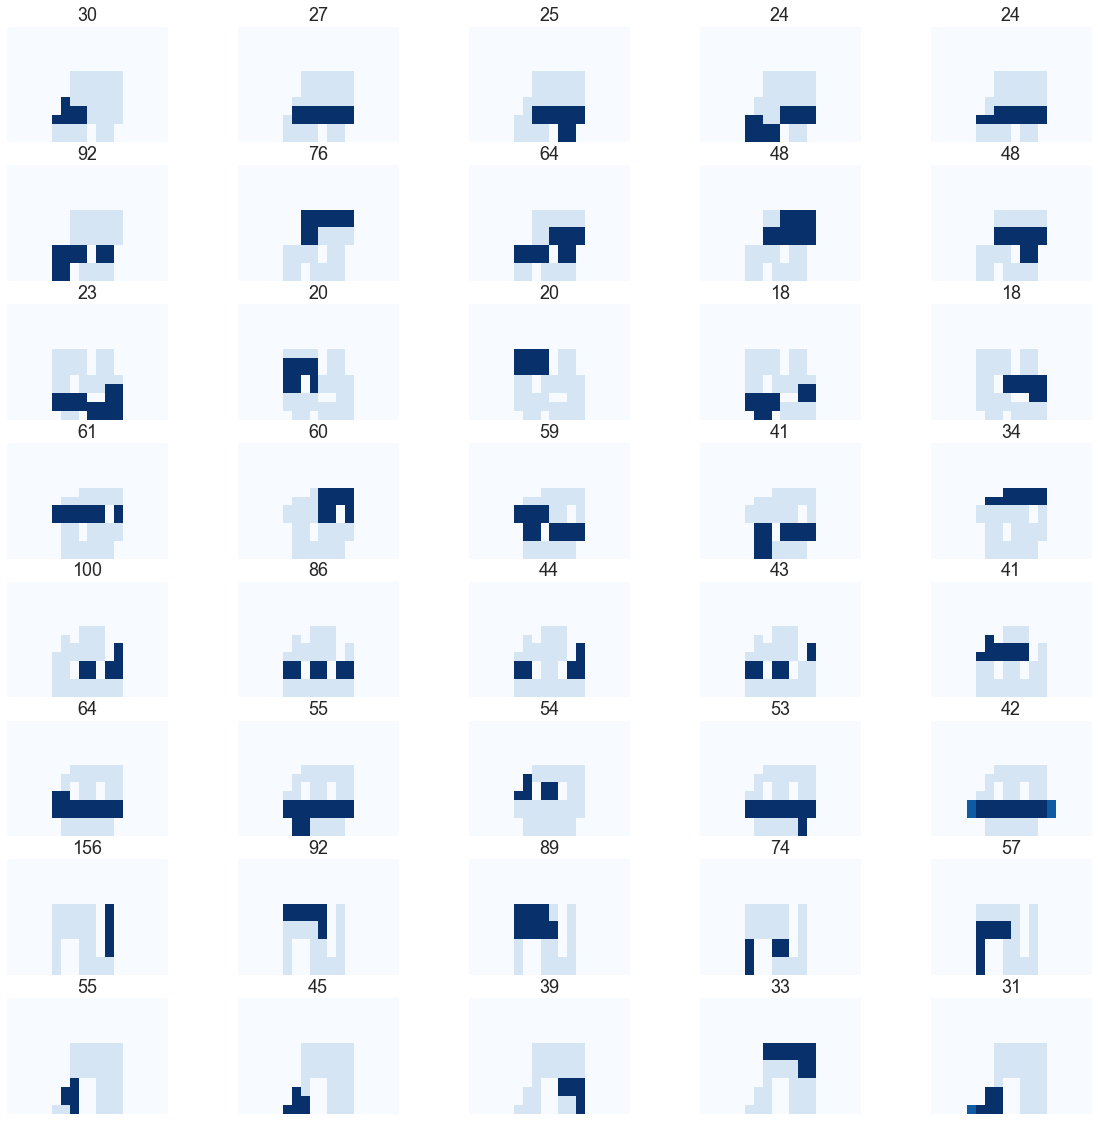

In [24]:
## for each ngram, draw the sequence of world states in one image (minus the rest of the image)

fig, axs = plt.subplots(len(targets), k, figsize=(20,20))

for i, t in enumerate(targets):
    for j in range(0,k):
        states = [top_k_diff[t][j][0]]

        axs[i,j].axis('off')
        axs[i,j].set_title(str(top_k_diff[t][j][1]))

        show_chunk(states, axs[i,j], target=t)


In [52]:
# CHUNK FREQUENCY: Which chunks tend to appear most frequently overall? (always within-tower, of course)
# do this for a range of window sizes


# this method uses first and last state states of ngrams of a given length to identify chunks. 
# therefore the first state displayed below isn't a block placement. 

chunk_range = range(3,8) # number of blocks + 1 for initial state
k = 10 # take top k most frequent chunks
chunk_data = {}

# make a dataframe with a group for each reconstruction
df_target_grouped = dfic.groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

for chunk_size in chunk_range:

    # Calculate the ngrams of a particular length for each reconstruction
    df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()

    chunk_data[chunk_size] = {}
    chunk_data[chunk_size]['ngram_list'] = {}
    chunk_data[chunk_size]['diff'] = {}
    chunk_data[chunk_size]['diff_counts'] = {}
    chunk_data[chunk_size]['top_k_diff'] = {}

    for t in targets:
        # for each target, put the ngrams from all reconstructions into list
        chunk_data[chunk_size]['ngram_list'][t] = [ngram for row in df_ngrams[df_ngrams.targetName==t]['flatDiscreteWorldStr'] for ngram in row]
        chunk_data[chunk_size]['diff'][t] = ["".join([str(a) for a in 
                      list((np.array(list(ngram[-1])).astype(np.int) - 
                         np.array(list(ngram[0])).astype(np.int)))]) for ngram in chunk_data[chunk_size]['ngram_list'][t]]
        chunk_data[chunk_size]['diff_counts'][t] = Counter(chunk_data[chunk_size]['diff'][t]) # count occurrences of each ngram across ppts
        chunk_data[chunk_size]['top_k_diff'][t] =  chunk_data[chunk_size]['diff_counts'][t].most_common(k)



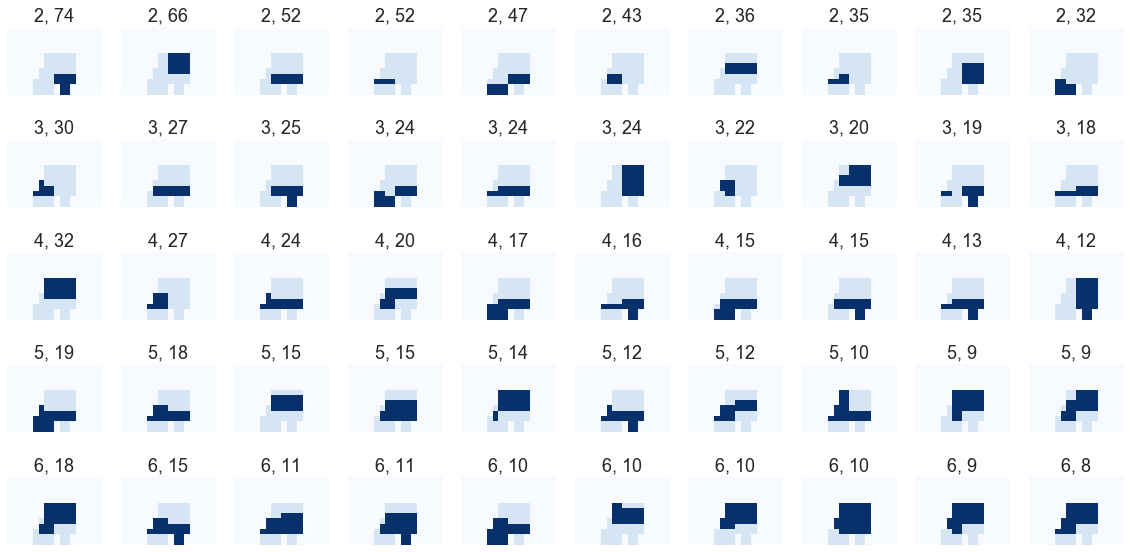

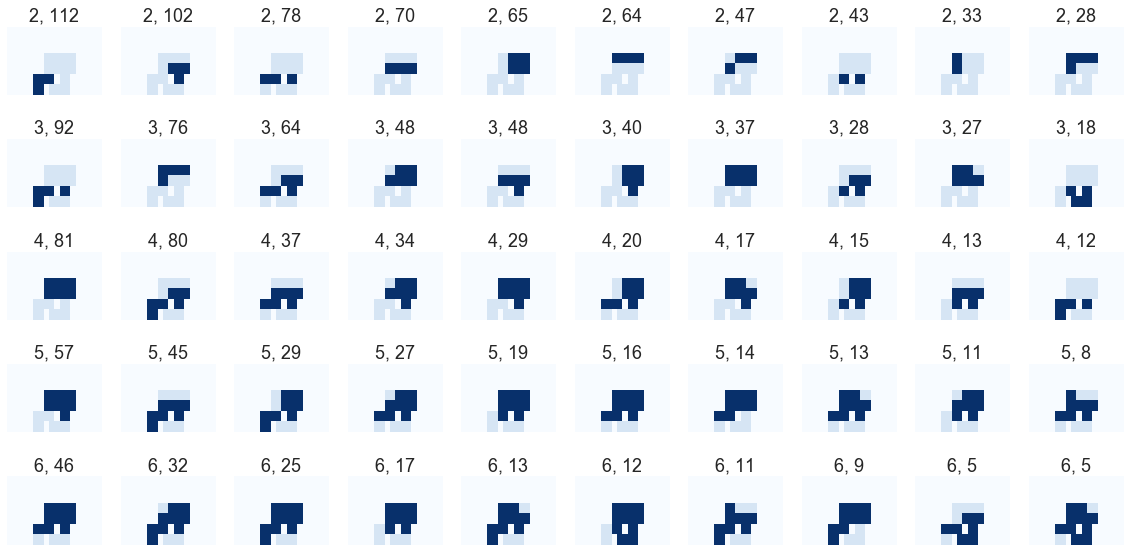

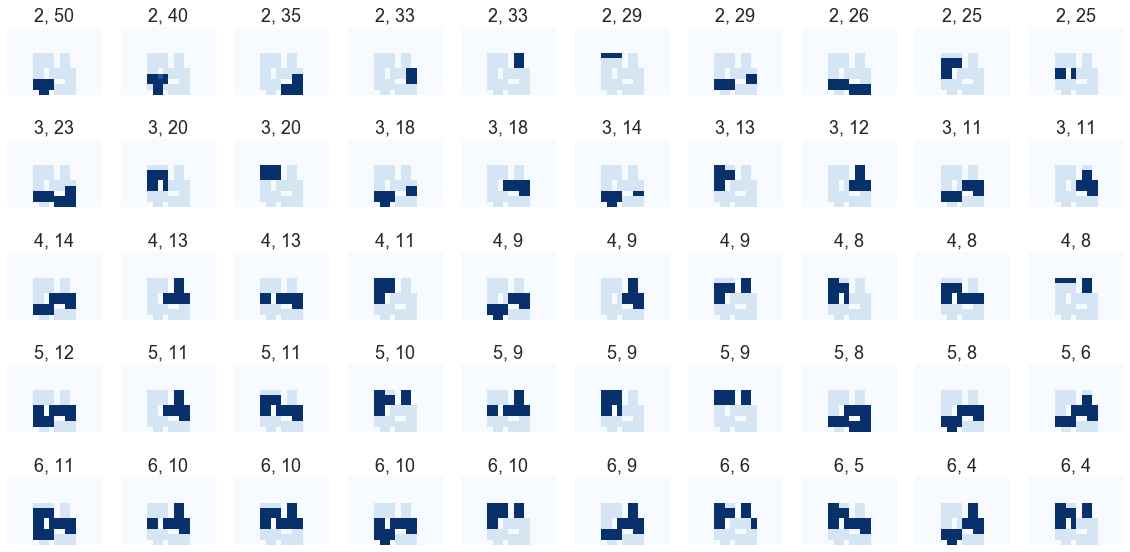

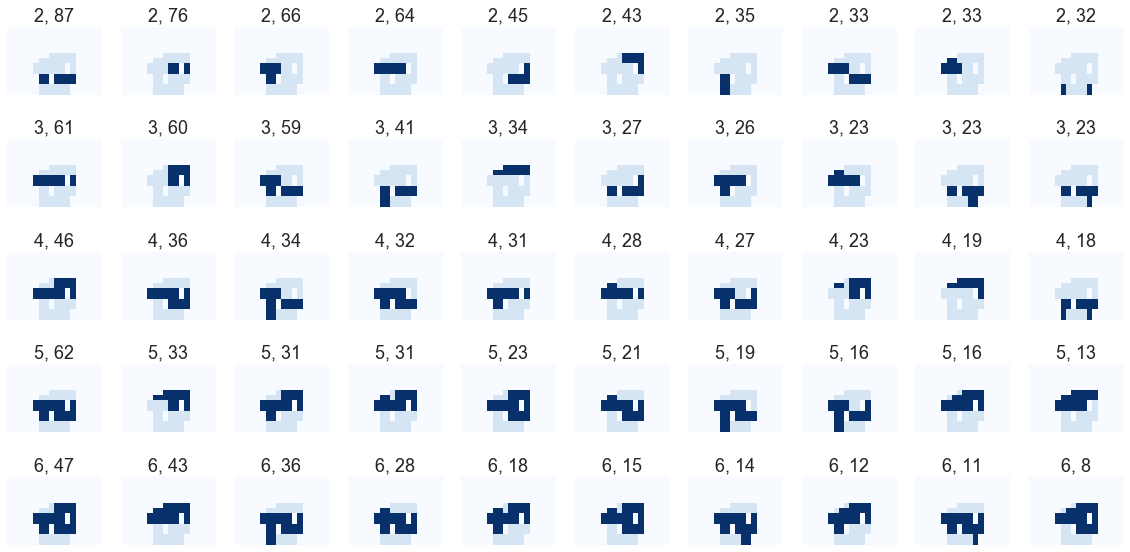

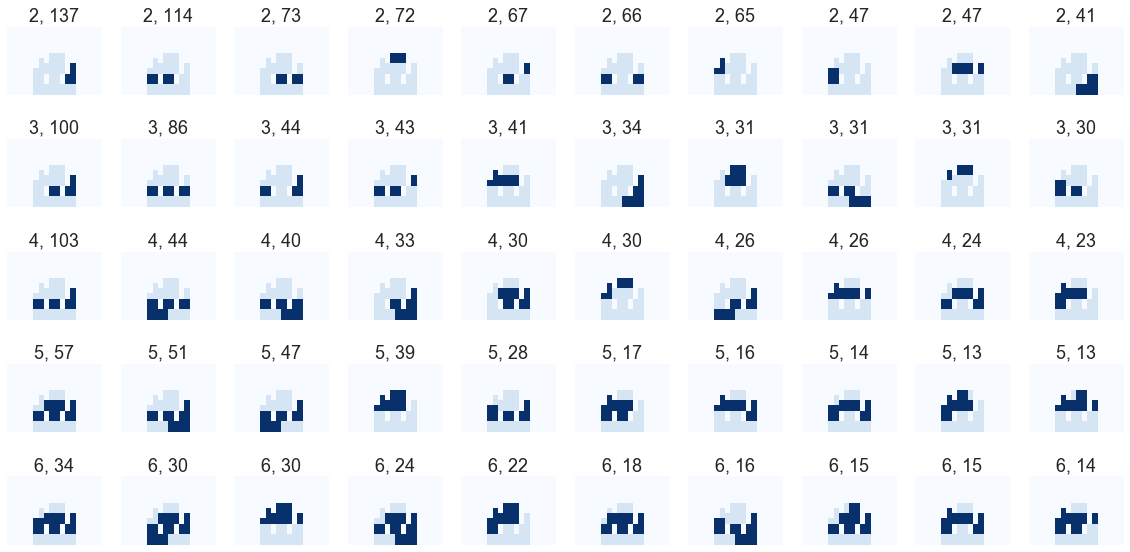

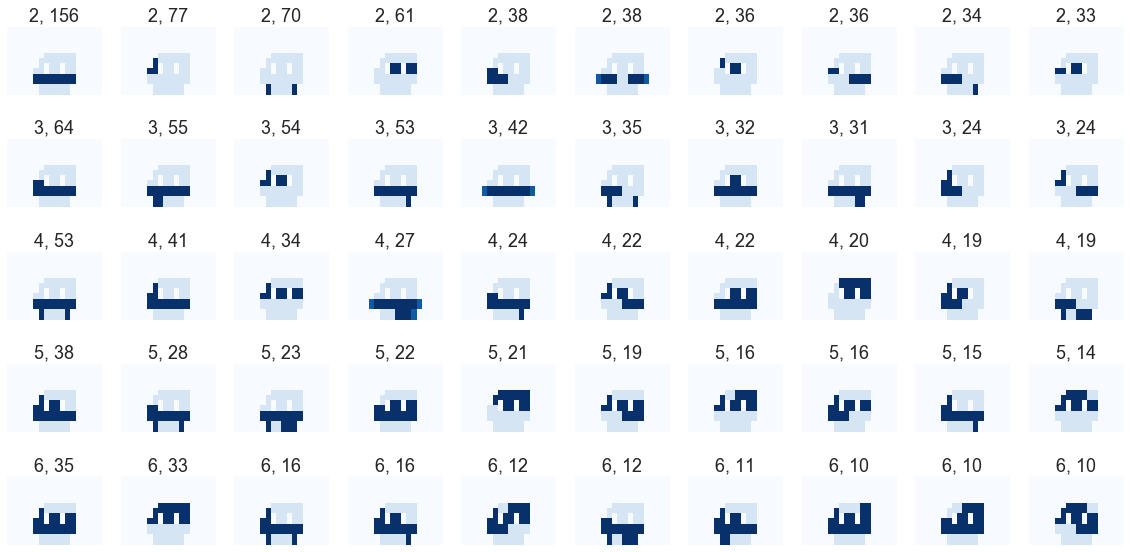

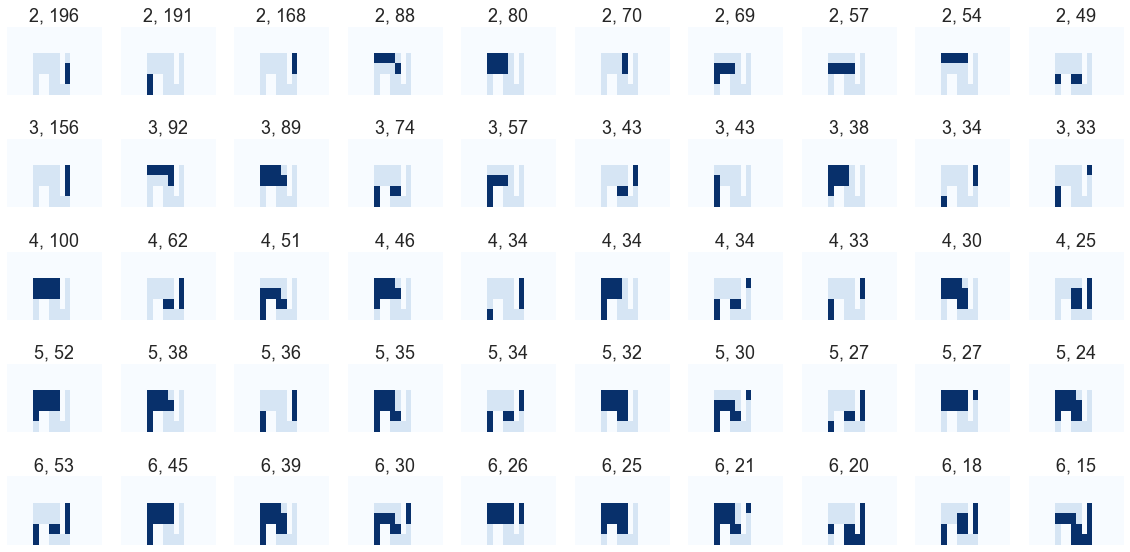

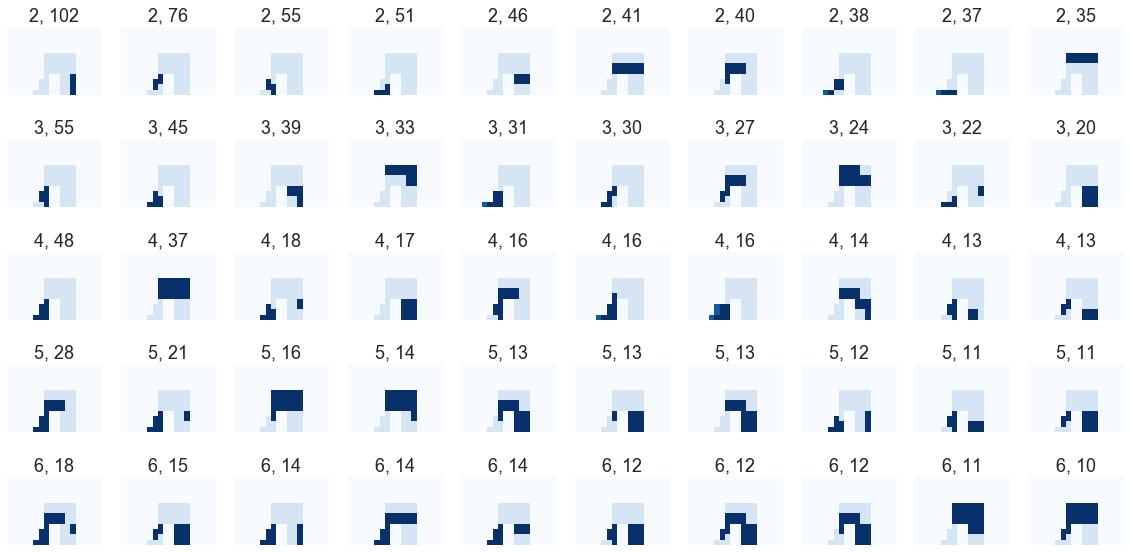

In [53]:
## for each ngram, draw the sequence of world states in one image (minus the rest of the image)


for t in targets:

#     print('chunk size: ', chunk_size)
    fig, axs = plt.subplots(len(chunk_range), k, figsize=(20,2*len(chunk_range))) # new figure for each target

    for csi, chunk_size in enumerate(chunk_range):
        for j in range(0,k):
            states = [chunk_data[chunk_size]['top_k_diff'][t][j][0]]

            axs[csi,j].axis('off')
            axs[csi,j].set_title(str(chunk_size - 1) + ', ' + str(chunk_data[chunk_size]['top_k_diff'][t][j][1]))

            show_chunk(states, axs[csi,j], target=t)

            


In [54]:
dfic.perfect

AttributeError: 'DataFrame' object has no attribute 'perfect'

In [78]:
# Which chunks tend to appear most frequently in perfect reconstructions?

# this method uses first and last state states of ngrams of a given length to identify chunks. 
# therefore the first state displayed below isn't a block placement. 

chunk_range = range(3,8) # number of blocks + 1 for initial state
k = 10 # take top k most frequent chunks
chunk_data = {}

# make a dataframe with a group for each reconstruction
df_target_grouped = dfic[dfic.perfectScore].groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

for chunk_size in chunk_range:

    # Calculate the ngrams of a particular length for each reconstruction
    df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()

    chunk_data[chunk_size] = {}
    chunk_data[chunk_size]['ngram_list'] = {}
    chunk_data[chunk_size]['diff'] = {}
    chunk_data[chunk_size]['diff_counts'] = {}
    chunk_data[chunk_size]['top_k_diff'] = {}

    for t in targets:
        # for each target, put the ngrams from all reconstructions into list
        chunk_data[chunk_size]['ngram_list'][t] = [ngram for row in df_ngrams[df_ngrams.targetName==t]['flatDiscreteWorldStr'] for ngram in row]
        chunk_data[chunk_size]['diff'][t] = ["".join([str(a) for a in 
                      list((np.array(list(ngram[-1])).astype(np.int) - 
                         np.array(list(ngram[0])).astype(np.int)))]) for ngram in chunk_data[chunk_size]['ngram_list'][t]]
        chunk_data[chunk_size]['diff_counts'][t] = Counter(chunk_data[chunk_size]['diff'][t]) # count occurrences of each ngram across ppts
        chunk_data[chunk_size]['top_k_diff'][t] =  chunk_data[chunk_size]['diff_counts'][t].most_common(k)



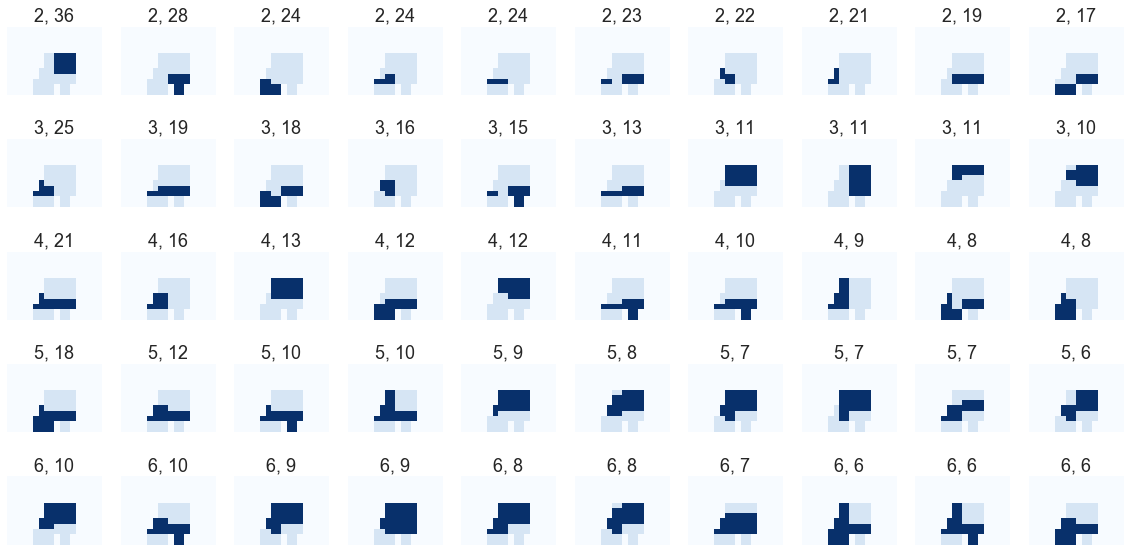

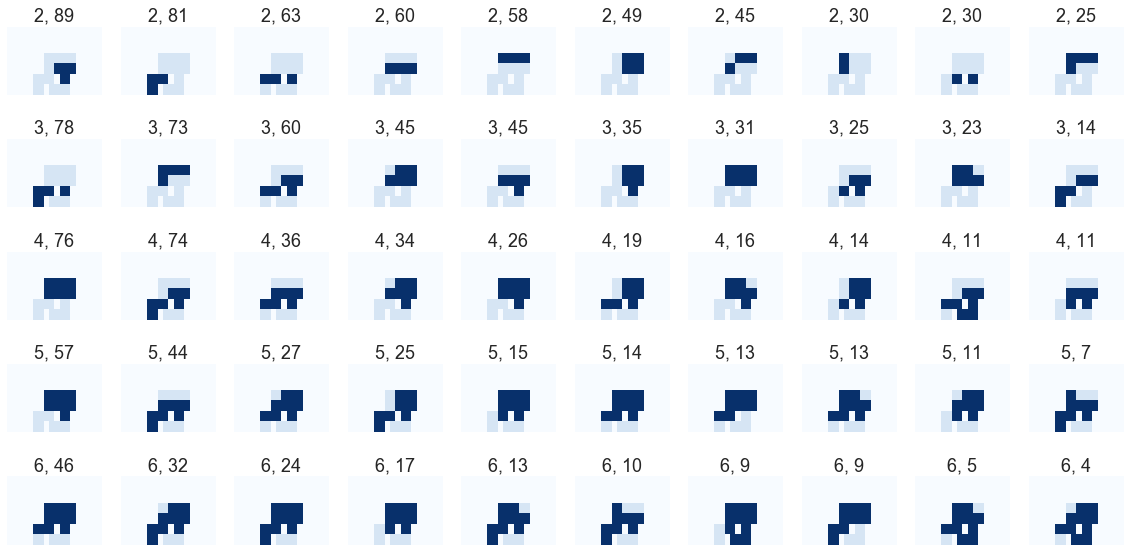

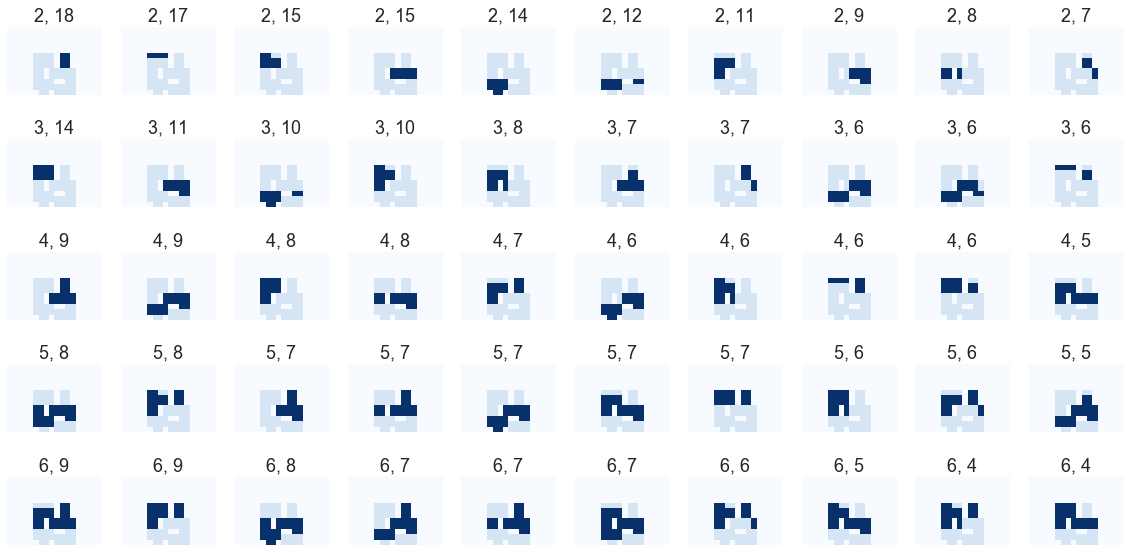

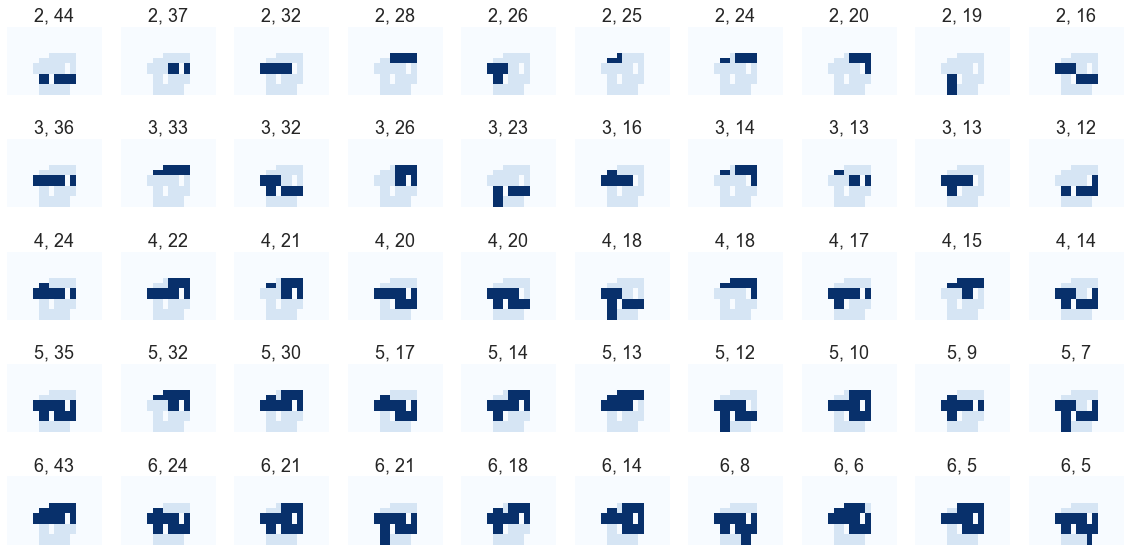

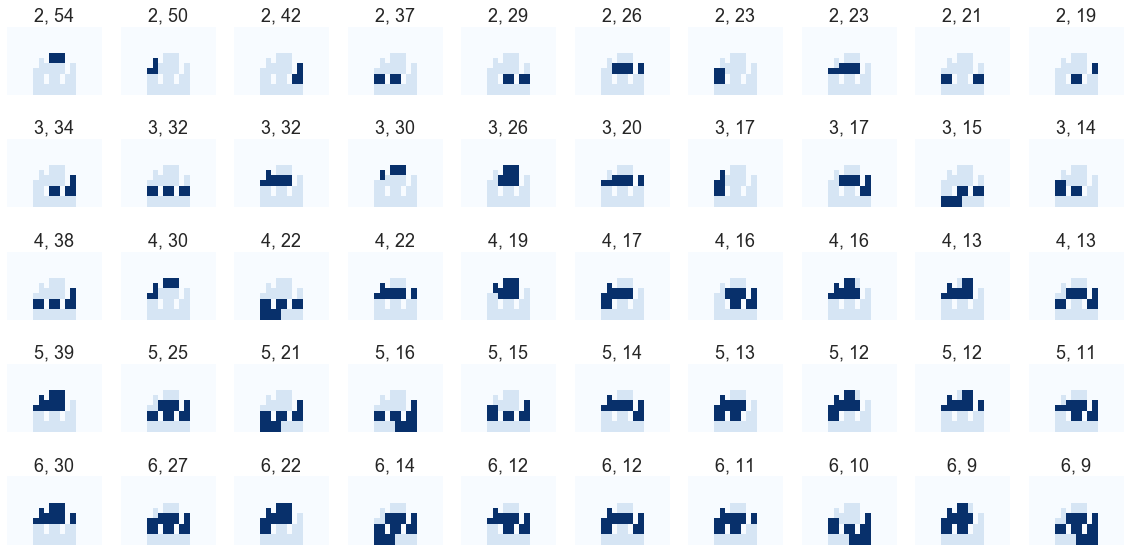

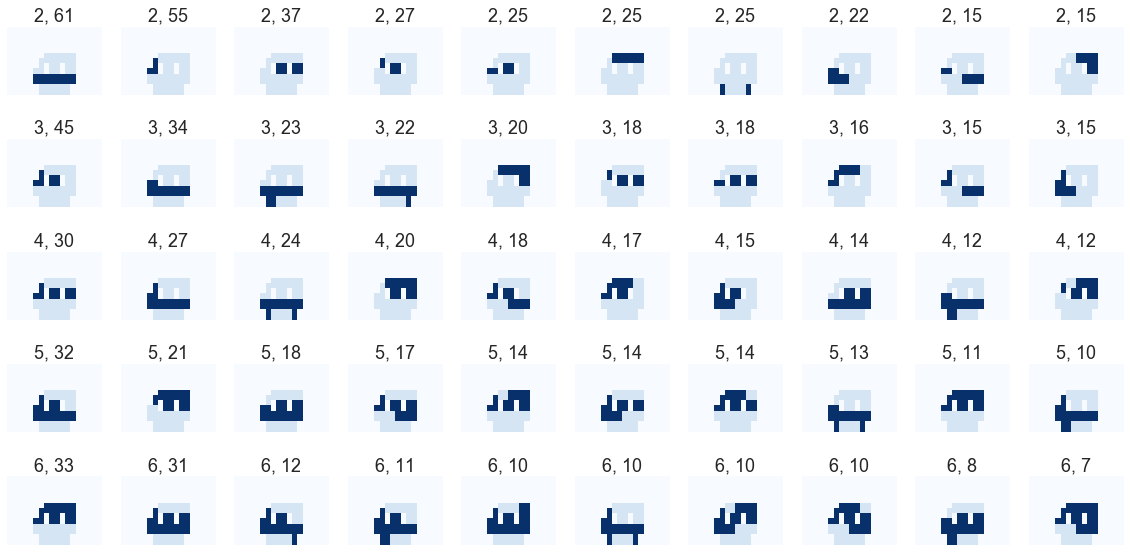

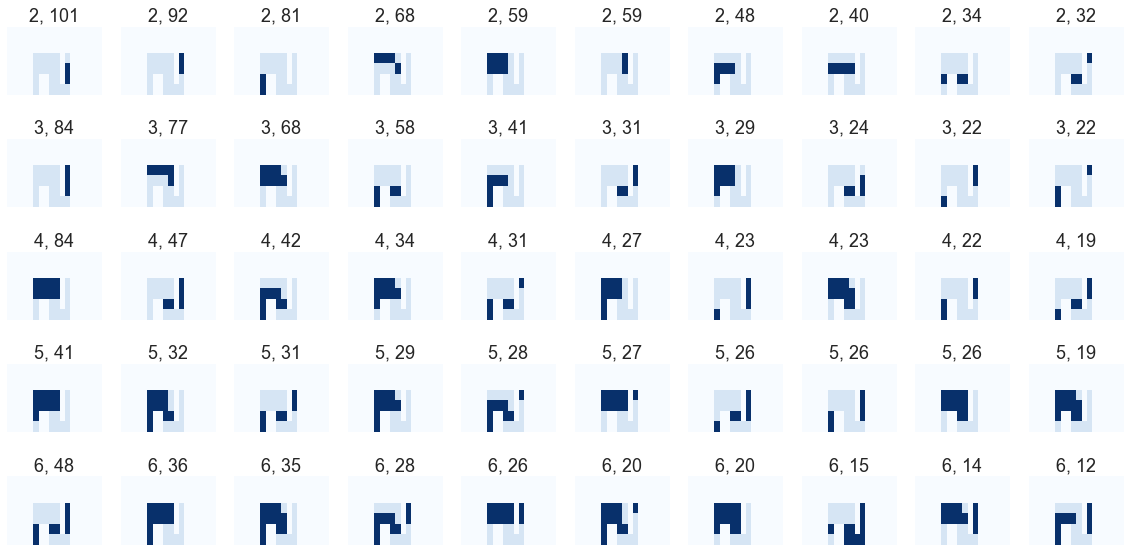

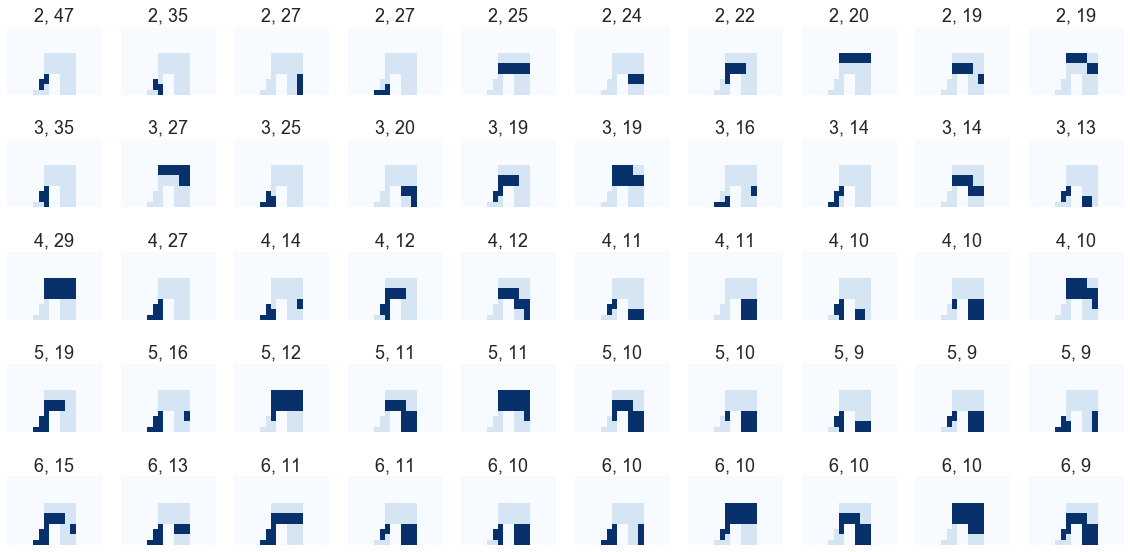

In [79]:
## for each ngram, draw the sequence of world states in one image (minus the rest of the image)

for t in targets:

#     print('chunk size: ', chunk_size)
    fig, axs = plt.subplots(len(chunk_range), k, figsize=(20,2*len(chunk_range))) # new figure for each target

    for csi, chunk_size in enumerate(chunk_range):
        for j in range(0,k):
            states = [chunk_data[chunk_size]['top_k_diff'][t][j][0]]

            axs[csi,j].axis('off')
            axs[csi,j].set_title(str(chunk_size - 1) + ', ' + str(chunk_data[chunk_size]['top_k_diff'][t][j][1]))

            show_chunk(states, axs[csi,j], target=t)

            


In [ ]:
# CHUNK FREQUENCY & ACCURACY: How strongly are these frequent chunks related to higher scores? How well do these chunks differentiate trials that are higher-scoring vs. lower-scoring? [W: i.e. are we identifying something that actually helps? We’re only considering imperfect reconstructions here] 
# Part 1: what is the average F1 score of trials containing each chunk? 
# Part 2: Is chunk popularity correlated with chunk F1 mean?
# Part 3: Is chunk popularity correlated with chunk F1 mean / s.d. (aka coefficient of variation)? In other words, do chunks that are highly popular also show up in trials that are consistently accurate (i.e., high mean, low sd)?


In [ ]:
# CHUNK FREQUENCY OVER TIME: For a given chunk, how much does its prevalence across people change across repetition number? 
# Relatedly, which chunks increase in prevalence the most? 


In [ ]:
# ACCURACY OVER TIME: For a given chunk, how much does the accuracy of trials containing it change across repetition number? 


In [ ]:
# CHUNK FREQUENCY & ACCURACY OVER TIME: Are the chunks that become more prevalent over time associated with improvement in task performance? I.e., across chunks, is there a relationship between the amount of change in that chunk’s frequency and the amount of change in F1 (mean or CV)?


### Does an individual start to use chunks?
Compare their last two building procedures: to what extent do they use the same subsequences?
Are they more similar at the end to at the beginning?

Strict: do people use the same subsequences of actions to build the same parts?
Less strict: do people decompose the structure in the same way, even if they use different actions to build each substructure? I.e. can their build sequences be partitioned into continuous sequences of actions that correspond to the same parts of the structure?

For each pair of block placements, get bitmap of difference in world. (this is what has happened in all actions between those two block placements, inclusive)

Find the minimum hierarchical reordering/ closest matching tree structure

If two subsequences have the same difference matrix, then they can be said to build the same chunk.
These chunks may occur in different orders, but that's fine- we want to know whether the same chunks are being built.

There are two whole matrices of difference matrices.
We want to find the longest (in amount of actions) differences in common.
But if we find two shorter chunks with a higher overall length then that's better..
Is that possible?


#### Step 1: visualize the chunks in common

look at world diffs of largest subsequences
if diffs are the same- that's a candidate matching chunk
Once you have some candidate matching chunks, find the non-overlapping collection that accounts for the most actions (in the smallest number of chunks)


#### Step 2: measure the extent to which the same chunks are used



#### Step 3: compare early and late reps? Or compare 1-4 and 3-4?
Although we'd also like to know whether they use chunks at all- not whether they use them more at the end



In [118]:
# Get sequences 1 and 2 (i.e. final two reps for a structure from one ppt)

# compute the difference in world state between each pair of block placements

# for action s1 in S1
    # for action s1 in S1

# for action s2 in S2
    # for action s2 in S2
    
# find matches in world states
# loop through all diffs in one sequence, output same shape matrix but with coordinates of unique matching diff

# now what do we have? a mapping of candidate chunks of different lengths, that may well overlap in the block placements they involve.
# need to find the biggest (in terms of number actions in both)
# find non-overlapping



In [8]:
# Get sequences 1 and 2 (i.e. final two reps for a structure from one ppt)
df = dfic[(dfic.repetition == 2) | (dfic.repetition == 3)]

# group into reconstruction sequences
df_procedures = df.groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

# compute the difference in world state between each pair of block placements
al



,targetName,gameID,blockNum,repetition,phase_extended,flatDiscreteWorld,usableDiscreteWorld,rawF1DiscreteScore,discreteWorld,flatDiscreteWorldStr
99,hand_selected_009,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,1,2,repetition 2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.285714,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...
100,hand_selected_009,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,2,2,repetition 2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.400000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...
101,hand_selected_009,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,3,2,repetition 2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.451613,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...
102,hand_selected_009,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,4,2,repetition 2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.628571,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...
103,hand_selected_009,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,5,2,repetition 2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.702703,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...
...,...,...,...,...,...,...,...,...,...,...
22734,hand_selected_004,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,5,3,post,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.594595,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...
22735,hand_selected_004,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,6,3,post,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.731707,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...
22736,hand_selected_004,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,7,3,post,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.790698,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...
22737,hand_selected_004,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,8,3,post,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.893617,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...


In [ ]:
# use actions?

# Get sequences 1 and 2 (i.e. final two reps for a structure from one ppt)

# Get the actions

# Find the largest matching subsequences

